# How to Develop a Least Squares Generative Adversarial Network (LSGAN) in Keras
The Least Squares Generative Adversarial Network, or LSGAN for short, is an extension to the GAN architecture that addresses the problem of __vanishing gradients and loss saturation.__

It is motivated by the desire to provide a __signal to the generator__ about __fake__ samples that are __far from the discriminator model’s decision boundary__ for classifying them as real or fake. The __further__ the generated images are from the decision boundary, the __larger__ the __error signal__ provided to the generator, encouraging the generation of more realistic images.

The LSGAN can be implemented with a __minor__ change to the __output__ layer of the __discriminator__ and the adoption of the least squares, or __L2 loss__ function.

In this tutorial, you will discover how to develop a least squares generative adversarial network.

After completing this tutorial, you will know:

- The LSGAN addresses vanishing gradients and loss saturation of the deep convolutional GAN.
- The LSGAN can be implemented by a mean squared error or L2 loss function for the discriminator model.
- How to implement the LSGAN model for generating handwritten digits for the MNIST dataset.

# Tutorial Overview
This tutorial is divided into three parts; they are:

- What Is Least Squares GAN
- How to Develop an LSGAN for MNIST Handwritten Digits
- How to Generate Images With LSGAN

# What is Least Squares GAN

The standard Generative Adversarial Network, or GAN for short, is an effective architecture for training an unsupervised generative model.

The architecture involves training a discriminator model to tell the difference between real (from the dataset) and fake (generated) images, and using the discriminator, in turn, to train the generator model. The generator is updated in such a way that it is encouraged to generate images that are more likely to fool the discriminator.

The discriminator is a __binary classifier__ and is trained using binary cross-entropy loss function. A limitation of this loss function is that it is primarily concerned with whether the predictions are correct or not, and less so with __how correct or incorrect__ they might be.

___Vanishing gradients___
The issue appears when we feed fake data from G to D and tells it that these are real data, because at that moment we are updating G as part of the GAN loss, and we want to see if we already trick the D, then no need to update the G in that case, so we pu the GT of those points as "real". In other words, as long as D says "fake" on G points, we keep updating G, else, we don't update G. If D is not good enough, it will say these are real points, which is the same as the GT, and so no gradient. However, what we want to do is that, even if D is still not good enough, it might say it's real but the distance from the boundary is small, so it's about to be fake. So we want to penalize that, even if the threshold gives "real" at the end.

_… when we use the fake samples to update the generator by making the discriminator believe they are from real data, it will cause almost no error because they are on the correct side, i.e., the real data side, of the decision boundary_

— Least Squares Generative Adversarial Networks, 2016.

This can be conceptualized in two dimensions as a __line__ or __decision boundary__ separating dots that represent real and fake images. The discriminator is responsible for devising the decision boundary to best separate real and fake images and the generator is responsible for creating new points that look like real points, confusing the discriminator.

The choice of cross-entropy loss means that points generated far from the boundary are right or wrong, but provide very little gradient information to the generator on how to generate better images.

This small gradient for generated images far from the decision boundary is referred to as a vanishing gradient problem or a loss saturation. __The loss function is unable to give a strong signal as to how to best update the model.__

The Least Squares Generative Adversarial Network, or LSGAN for short, is an extension to the GAN architecture proposed by Xudong Mao, et al. in their 2016 paper titled ___“Least Squares Generative Adversarial Networks.”___ The LSGAN is a modification to the GAN architecture that changes the loss function for the __discriminator__ from binary cross entropy to a __least squares loss.__

The motivation for this change is that the least squares loss will __penalize__ generated images based on their __distance from the decision boundary__. This will provide a strong gradient signal for generated images that are very different or far from the existing data and address the problem of saturated loss.

_… minimizing the objective function of regular GAN suffers from vanishing gradients, which makes it hard to update the generator. LSGANs can relieve this problem because LSGANs penalize samples based on their distances to the decision boundary, which generates more gradients to update the generator._

— Least Squares Generative Adversarial Networks, 2016.

This can be conceptualized with a plot, below, taken from the paper, that shows on the left the sigmoid decision boundary (blue) and generated fake points far from the decision boundary (pink), and on the right the least squares decision boundary (red) and the points far from the boundary (pink) given a gradient that moves them closer to the boundary.

![dec_bndry](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/Plot-of-the-Sigmoid-Decision-Boundary-vs-the-Least-Squared-Decision-Boundary-for-Updating-the-Generator.png)

In addition to avoiding loss saturation, the LSGAN also results in a more stable training process and the generation of higher quality and larger images than the traditional deep convolutional GAN.

_First, LSGANs are able to generate higher quality images than regular GANs. Second, LSGANs perform more stable during the learning process._

— Least Squares Generative Adversarial Networks, 2016.

The LSGAN can be implemented by using the __target values__ of __1.0 for real and 0.0 for fake__ images and optimizing the model using the __mean squared error (MSE) loss function__, e.g. __L2 loss__. The __output layer__ of the __discriminator__ model must be a __linear__ activation function.

The authors propose a __generator__ and __discriminator__ model architecture, inspired by the __VGG model architecture__, and use interleaving upsampling and normal convolutional layers in the generator model, seen on the left in the image below.

![VGG_Arch](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/Summary-of-the-Generator-left-and-Discriminator-right-Model-Architectures-used-in-LSGAN-Experiments.png)

# How to Develop an LSGAN for MNIST Handwritten Digits
In this section, we will develop an LSGAN for the MNIST handwritten digit dataset.

The first step is to define the models.

Both the discriminator and the generator will be based on the Deep Convolutional GAN, or DCGAN, architecture. This involves the use of Convolution-BatchNorm-Activation layer blocks with the use of 2×2 stride for downsampling and transpose convolutional layers for upsampling. LeakyReLU activation layers are used in the discriminator and ReLU activation layers are used in the generator.

# D
The discriminator expects grayscale input images with the shape 28×28, the shape of images in the MNIST dataset, and the __output layer__ is a single node with a __linear__ activation function. The model is optimized using the mean squared error __(MSE) loss__ function as per the LSGAN. 

The `define_discriminator()` function below defines the discriminator model.

In [0]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# downsample to 14x14
	model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init, input_shape=in_shape))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 7x7
	model.add(Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dense(1, activation='linear', kernel_initializer=init))
	# compile model with L2 loss
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

# G
The generator model takes a point in latent space as input and outputs a grayscale image with the shape 28×28 pixels, where pixel values are in the range [-1,1] via the __tanh__ activation function on the output layer.

The `define_generator()` function below defines the generator model. 
___This model is not compiled as it is not trained in a standalone manner.___

In [0]:
# define the standalone generator model
def define_generator(latent_dim):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# define model
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 256 * 7 * 7
	model.add(Dense(n_nodes, kernel_initializer=init, input_dim=latent_dim))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(Reshape((7, 7, 256)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	# upsample to 28x28
	model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	# output 28x28x1
	model.add(Conv2D(1, (7,7), padding='same', kernel_initializer=init))
	model.add(Activation('tanh'))
	return model

# GAN
The generator model is updated via the discriminator model. This is achieved by creating a composite model that stacks the generator on top of the discriminator so that error signals can flow back through the discriminator to the generator.

The weights of the __discriminator are marked as not trainable__ when used in this composite model. Updates via the composite model involve using the generator to create new images by providing random points in the latent space as input. The generated images are passed to the discriminator, which will classify them as real or fake. The weights are updated as though the generated images are real (e.g. target of 1.0), allowing the generator to be updated toward generating more realistic images.

The `define_gan()` function defines and compiles the composite model for ___updating the generator model via the discriminator___, again optimized via __mean squared error__ as per the LSGAN.

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model with L2 loss
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

# Data prep
Next, we can define a function to load the MNIST handwritten digit dataset and scale the pixel values to the range [-1,1] to match the images output by the generator model.

Only the training part of the MNIST dataset is used, which contains 60,000 centered grayscale images of digits zero through nine.

In [0]:
# load mnist images
def load_real_samples():
	# load dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

We can then define a function to retrieve a batch of randomly selected images from the training dataset.

The real images are returned with corresponding target values for the discriminator model, e.g. y=1.0, to indicate they are real.

In [0]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

Next, we can develop the corresponding functions for the generator.

First, a function for generating random points in the latent space to use as input for generating images via the generator model.

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

Next, a function that will use the generator model to generate a batch of fake images for updating the discriminator model, along with the target value (y=0) to indicate the images are fake.

In [0]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

We need to use the generator periodically during training to generate images that we can subjectively inspect and use as the basis for choosing a final generator model.

The `summarize_performance()` function below can be called during training to generate and save a plot of images and save the generator model. Images are plotted using a reverse grayscale color map to make the digits black on a white background.

In [0]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(10 * 10):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%06d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('Saved %s and %s' % (filename1, filename2))

We are also interested in the behavior of loss during training.

As such, we can record loss in lists across each training iteration, then create and save a line plot of the learning dynamics of the models. Creating and saving the plot of learning curves is implemented in the `plot_history()` function.

In [0]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
	pyplot.plot(d1_hist, label='dloss1')
	pyplot.plot(d2_hist, label='dloss2')
	pyplot.plot(g_hist, label='gloss')
	pyplot.legend()
	filename = 'plot_line_plot_loss.png'
	pyplot.savefig(filename)
	pyplot.close()
	print('Saved %s' % (filename))

# Train
Finally, we can define the main training loop via the `train()` function.

The function takes the defined models and dataset as arguments and parameterizes the number of training epochs and batch size as default function arguments.

Each training loop involves first generating a half-batch of real and fake samples and using them to create one batch worth of weight updates to the discriminator. Next, the generator is updated via the composite model, providing the real (y=1) target as the expected output for the model.

The loss is reported each training iteration, and the model performance is summarized in terms of a plot of generated images at the end of every epoch. The plot of learning curves is created and saved at the end of the run.

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=64):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for storing loss, for plotting later
	d1_hist, d2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# prepare real and fake samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update the generator via the discriminator's error
		z_input = generate_latent_points(latent_dim, n_batch)
		y_real2 = ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(z_input, y_real2)
		# summarize loss on this batch
		print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))
		# record history
		d1_hist.append(d_loss1)
		d2_hist.append(d_loss2)
		g_hist.append(g_loss)
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model, latent_dim)
	# create line plot of training history
	plot_history(d1_hist, d2_hist, g_hist)

Tying all of this together, the complete code example of training an LSGAN on the MNIST handwritten digit dataset is listed below.

In [18]:
# example of lsgan for mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import Activation
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from matplotlib import pyplot

# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
print(dataset.shape)
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

(60000, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, d1=0.681, d2=0.245 g=1.403
>2, d1=1.029, d2=4.135 g=1.337
>3, d1=1.598, d2=0.824 g=2.380


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>4, d1=1.253, d2=0.826 g=1.492
>5, d1=0.352, d2=1.998 g=2.582
>6, d1=0.589, d2=0.716 g=2.171
>7, d1=0.724, d2=1.862 g=2.319
>8, d1=0.431, d2=0.622 g=3.178
>9, d1=0.535, d2=0.583 g=2.539
>10, d1=0.644, d2=0.707 g=2.894
>11, d1=0.488, d2=0.653 g=0.447
>12, d1=0.396, d2=2.553 g=3.239
>13, d1=0.759, d2=2.247 g=0.367
>14, d1=0.581, d2=4.355 g=2.265
>15, d1=0.667, d2=1.355 g=1.006
>16, d1=0.344, d2=2.339 g=1.487
>17, d1=0.425, d2=0.677 g=1.607
>18, d1=0.359, d2=0.669 g=1.272
>19, d1=0.369, d2=0.405 g=0.629
>20, d1=0.150, d2=1.070 g=2.135
>21, d1=0.546, d2=1.184 g=0.537
>22, d1=0.402, d2=2.514 g=2.251
>23, d1=0.299, d2=1.896 g=0.454
>24, d1=0.349, d2=1.847 g=0.786
>25, d1=0.637, d2=0.577 g=0.501
>26, d1=0.288, d2=0.494 g=0.281
>27, d1=0.185, d2=0.406 g=0.322
>28, d1=0.278, d2=0.609 g=0.647
>29, d1=0.175, d2=0.603 g=0.214
>30, d1=0.193, d2=0.559 g=0.501
>31, d1=0.131, d2=0.325 g=0.522
>32, d1=0.272, d2=0.390 g=0.365
>33, d1=0.301, d2=0.279 g=0.461
>34, d1=0.140, d2=0.258 g=0.333
>35, d1=0.169,

Running the example will report the loss of the discriminator on real (d1) and fake (d2) examples and the loss of the generator via the discriminator on generated examples presented as real (g). These scores are printed at the end of each training run and are expected to remain small values throughout the training process. Values of zero for an extended period may indicate a failure mode and the training process should be restarted.

Note: your specific results will vary given the stochastic nature of the learning algorithm.

At the end of the training run, a plot of learning curves is created for the discriminator and generator.

In this case, we can see that training remains somewhat stable throughout the run, with some very large peaks observed, which wash out the scale of the plot.

# How to Generate Images With LSGAN
We can use the saved generator model to create new images on demand.

This can be achieved by first selecting a final model based on image quality, then loading it and providing new points from the latent space as input in order to generate new plausible images from the domain.

In this case, we will use the model saved after 20 epochs, or 18,740 (60K/64 or 937 batches per epoch * 20 epochs) training iterations.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


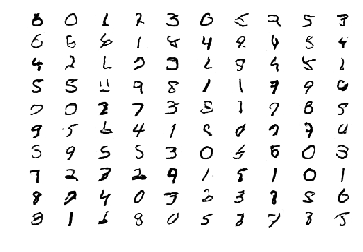

In [20]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot


# create a plot of generated images (reversed grayscale)
def plot_generated(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('model_018740.h5')
#model = load_model('model_000937.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# plot the result
plot_generated(X, 10)